In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0719 18:52:49.100851 4407242176 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Train neural network

In [9]:
#Configurations
eps_train = None                                                                                                                            
eps_test = None 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (1,)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 100, 0.00, 3e-2, 8 # Will have to experiment with learning rate a bit.                                                                                              

In [10]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((x_train, y_train), (x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma,  classification = False)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        returned = model.fit(sess, x_train, y_train, training_epochs = epochs, reg_op = reg , lr = lr, batch_size = batch_size, x_test = x_test)
        
        preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0719 18:52:50.258299 4407242176 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0719 18:52:50.259621 4407242176 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0719 18:52:50.269532 4407242176 feedforward_robust.py:40] Created placeholders for x and y
W0719 18:52:50.272250 4407242176 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0719 18:52:50.272954 4407242176 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0719 18:52:50.273982 4407242176 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0719 18:52:50.948482 4407242176 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
Epoch: 0001    cost: 0.440991700 
I0719 18:52:51.201318 4407242176 feedforward_robust.py:763] Epoch: 0001    cost: 0.440991700 
Accuracy on batch: 0.375000
I0719 18:52:51.204998 4407242176 feedforward_robust.py:764] Accuracy on batch: 0.375000
Epoch: 0002    cost: 0.265166789 
I0719 18:52:51.218847 4407242176 feedforward_robust.py:763] Epoch: 0002    cost: 0.265166789 
Accuracy on batch: 0.500000
I0719 18:52:51.222187 4407242176 feedforward_robust.py:764] Accuracy on batch: 0.500000
Epoch: 0003    cost: 0.239867151 
I0719 18:52:51.239125 4407242176 feedforward_robust.py:763] Epoch: 0003    cost: 0.239867151 
Accuracy on batch: 0.500000
I0719 18:52:51.241392 4407242176 fe

Accuracy on batch: 1.000000
I0719 18:52:51.775537 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0034    cost: 0.004261260 
I0719 18:52:51.789011 4407242176 feedforward_robust.py:763] Epoch: 0034    cost: 0.004261260 
Accuracy on batch: 1.000000
I0719 18:52:51.793339 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0035    cost: 0.003912436 
I0719 18:52:51.805674 4407242176 feedforward_robust.py:763] Epoch: 0035    cost: 0.003912436 
Accuracy on batch: 1.000000
I0719 18:52:51.809637 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0036    cost: 0.002894450 
I0719 18:52:51.823801 4407242176 feedforward_robust.py:763] Epoch: 0036    cost: 0.002894450 
Accuracy on batch: 1.000000
I0719 18:52:51.827279 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0037    cost: 0.003283289 
I0719 18:52:51.840390 4407242176 feedforward_robust.py:763] Epoch: 0037    cost: 0.003283289 
Accuracy on batch: 1.000

I0719 18:52:52.289057 4407242176 feedforward_robust.py:763] Epoch: 0067    cost: 0.000112152 
Accuracy on batch: 1.000000
I0719 18:52:52.293492 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0068    cost: 0.000093133 
I0719 18:52:52.305401 4407242176 feedforward_robust.py:763] Epoch: 0068    cost: 0.000093133 
Accuracy on batch: 1.000000
I0719 18:52:52.308115 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0069    cost: 0.000074631 
I0719 18:52:52.320200 4407242176 feedforward_robust.py:763] Epoch: 0069    cost: 0.000074631 
Accuracy on batch: 1.000000
I0719 18:52:52.322849 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0070    cost: 0.000054991 
I0719 18:52:52.334064 4407242176 feedforward_robust.py:763] Epoch: 0070    cost: 0.000054991 
Accuracy on batch: 1.000000
I0719 18:52:52.338918 4407242176 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0071    cost: 0.000046710 
I0719 18:52:52.350153 44

Optimization Finished!
I0719 18:52:52.762069 4407242176 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.000004
I0719 18:52:52.792249 4407242176 feedforward_robust.py:773] Final Train Loss 0.000004
Final Train Accuracy 1.000000:
I0719 18:52:52.793959 4407242176 feedforward_robust.py:774] Final Train Accuracy 1.000000:
Model was trained on benign data
I0719 18:52:52.795573 4407242176 feedforward_robust.py:796] Model was trained on benign data
Model was evaluated on benign data
I0719 18:52:52.800552 4407242176 feedforward_robust.py:675] Model was evaluated on benign data


----Regular loss and accuracy ----
(0.054166496, 0.9295)


In [11]:
feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [12]:
feat_list.shape

(100, 10000, 5)

In [13]:
preds_list.shape

(100, 10000, 2)

In [14]:
preds_list[0, 0]

array([0.712157  , 0.97062624], dtype=float32)

# Processing preds and plotting

In [15]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [16]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [17]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(100, 10000)

In [18]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(100,)

In [19]:
preds_means

array([0.38429996, 0.58111775, 0.38041493, 0.44503075, 0.6237522 ,
       0.7934522 , 0.72800004, 0.60550916, 0.56820476, 0.6139293 ,
       0.7140621 , 0.7997465 , 0.82006526, 0.7971589 , 0.79702395,
       0.8540656 , 0.941324  , 0.9853506 , 0.9361811 , 0.8551302 ,
       0.8451743 , 0.92521966, 1.0281842 , 1.0470647 , 0.9843557 ,
       0.93435323, 0.96011233, 1.0340843 , 1.0638751 , 1.0135516 ,
       0.9563166 , 0.96633905, 1.0178436 , 1.0278887 , 0.9868109 ,
       0.96667725, 0.9978293 , 1.0294877 , 1.0074358 , 0.96305263,
       0.9537719 , 0.9819977 , 0.9912802 , 0.971628  , 0.95408875,
       0.9576676 , 0.97367716, 0.9718446 , 0.9502794 , 0.9379366 ,
       0.94930106, 0.96117586, 0.95083946, 0.9324529 , 0.93323964,
       0.9482934 , 0.9509413 , 0.9362746 , 0.9288991 , 0.93984413,
       0.9499183 , 0.9428876 , 0.93316054, 0.93856484, 0.9502025 ,
       0.9492258 , 0.9403939 , 0.94193923, 0.95249736, 0.9549094 ,
       0.94767743, 0.94668937, 0.9551679 , 0.95879084, 0.95313

In [20]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [21]:
indices = np.arange(0, 100, 20)
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(5, 10000)

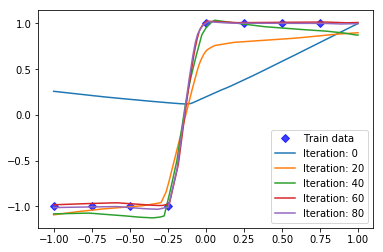

In [22]:
plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)

plt.legend()

# Processing feats and plotting

In [23]:
feats_select = feat_list[-1]

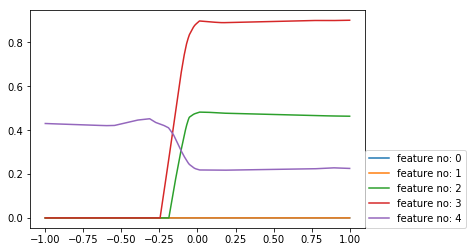

In [25]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
plt.legend(loc = (1, 0))